## VAE Hawkes Process Estimation - Tutorial

In [5]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
from dl.lstm_model import LSTMTrainer
from dl.vae_model import VAETrainer
from dl.dueling_decoder import DuelingTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors, integrate_intensity
from hawkes.simulation import hawkes_simulations, MLE
from hawkes.discretisation import discretise
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import read_parquet, timer
from visualization.error_viz import convergence_rate, errors_boxplots, effects_boxplots, reconstruction_plot, density_plot
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing

In [73]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = hyper_params_simulation(filename="all_models/hawkes_hyperparams_delta_0.25.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename="all_models/hawkes_simulations_train_delta_0.25.parquet")

# Discretized hawkes process
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="all_models/binned_hawkes_simulations_train_delta_0.25.parquet")

### Training

In [2]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("deltas_lstm/binned_hawkes_simulations_train_delta_0.5.parquet")
y = read_parquet("deltas_lstm/hawkes_hyperparams_train_delta_0.5.parquet")

# train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, x) 
# train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, np.column_stack((x, y[['eta', 'mu']])))
train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[['eta', 'mu']])
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [3]:
# Trained models

# model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
model, train_losses, val_losses, val_y_pred, val_eta, val_mu = LSTMTrainer().train_model(train_loader, val_loader, val_x, val_y)

# model, train_losses, val_losses, val_x_pred = VAETrainer().train_model(train_loader, val_loader, val_x, val_y)
# model, train_losses, val_losses, val_x_pred = DuelingTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
LSTM                                     [10000, 200]              [10000, 2]                --                             --                   --                        --                        True
├─LSTM: 1-1                              [10000, 200]              [10000, 64]               101,376                    99.87%                   --                        64,880,640,000            True
├─Linear: 1-2                            [10000, 64]               [10000, 2]                130                         0.13%                   --                        1,300,000                 True
Total params: 101,506
Trainable params: 101,506
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 64.88
Input size (MB): 8.00
Forward/backward pass size (MB): 5.28
Params size (M

Epoch 500/500 - train_loss: 0.0809, val_loss: 0.1144: 100%|██████████| 500/500 [2:13:06<00:00, 15.97s/it]  


Best model loading (2023_07_07_21_20_10_MICSHPEG8GIRARD_best_model.pt)...
Validation set - Estimated branching ratio (η): 0.4192, Estimated baseline intensity (µ): 2.8849


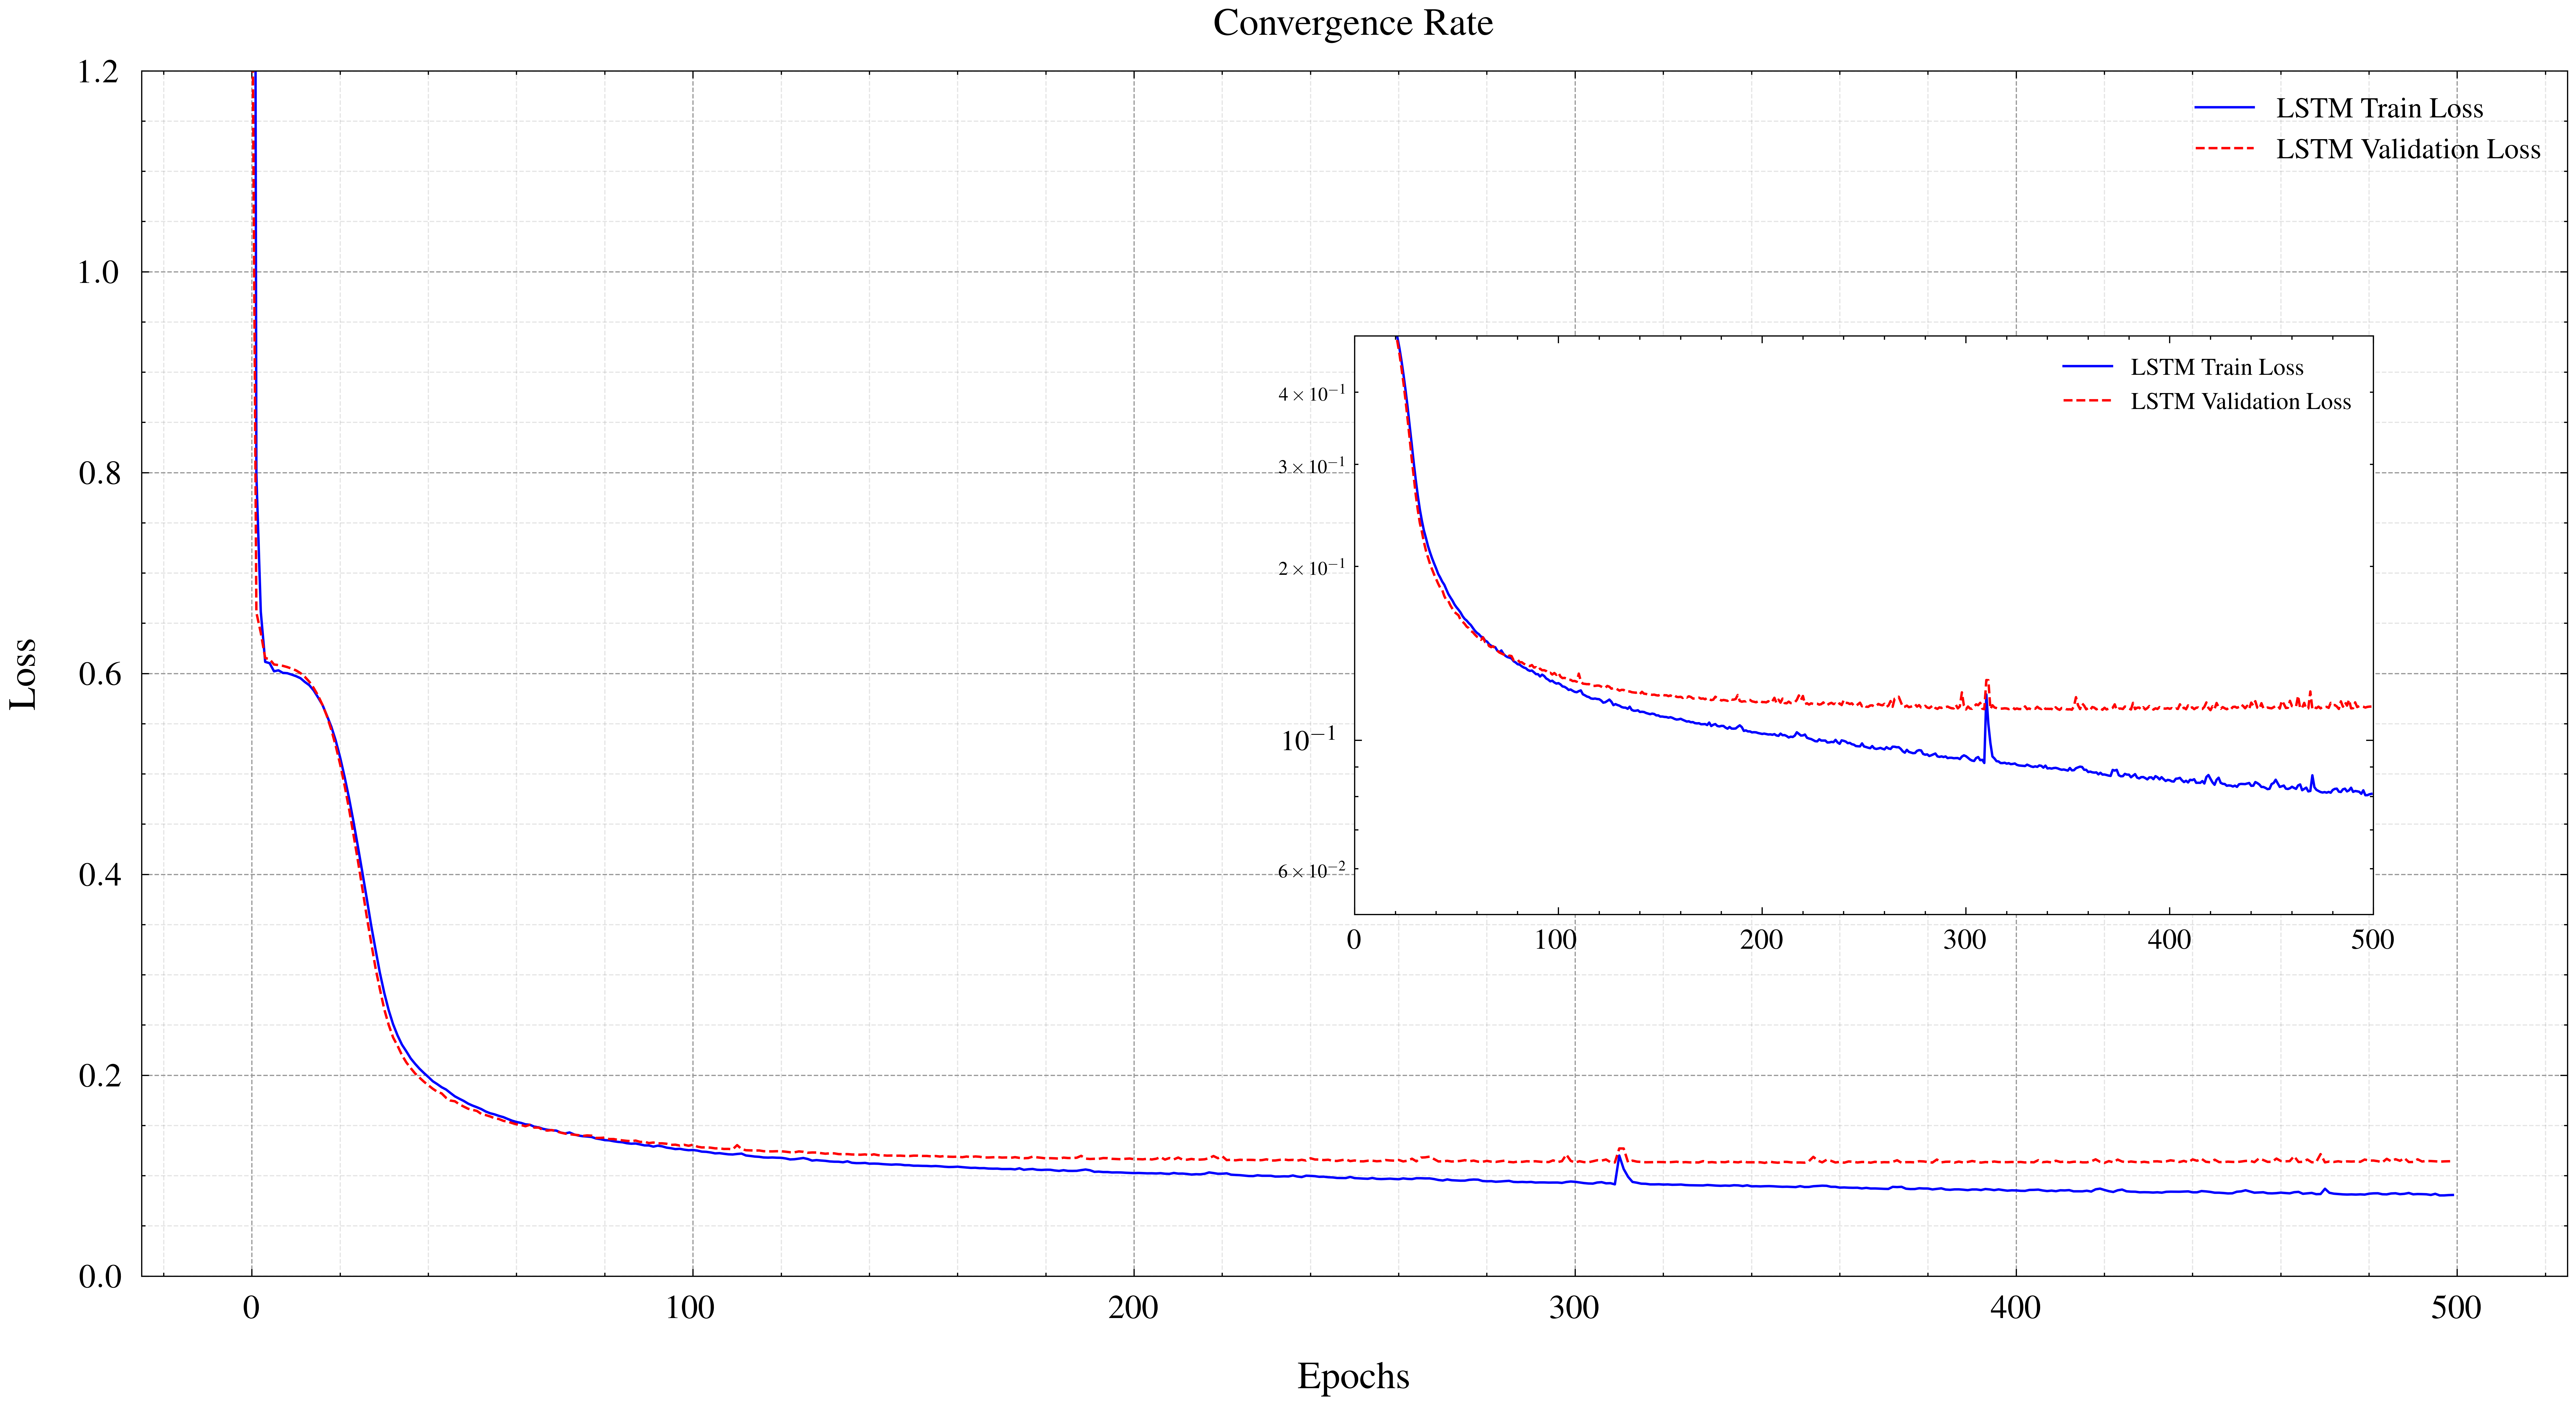

In [4]:
# Convergence rate plots

# bench_losses = read_parquet('benchmark/losses_benchmark.parquet')
# mlp_losses = read_parquet('br_mlp/losses_mlp_br_0.05_0.8.parquet')
lstm_losses = read_parquet('deltas_lstm/losses_lstm_delta_0.5.parquet')
# vae_losses = read_parquet('vae/losses_vae.parquet')
# dd_losses = read_parquet('dueling_decoder/losses_dueling_decoder.parquet')

convergence_rate(losses=[lstm_losses], models=["LSTM"], colors=["blue", "red"])

### Testing

In [6]:
# Tested models (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

# x = read_parquet("br_mlp/binned_hawkes_simulations_br_0.05_0.8.parquet")
# y = read_parquet("br_mlp/hawkes_hyperparams_br_0.05_0.8.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
# test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)

x = read_parquet("deltas_lstm/binned_hawkes_simulations_delta_0.5.parquet")
y = read_parquet("deltas_lstm/hawkes_hyperparams_delta_0.5.parquet")

test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
test_y_pred, _, _ = LSTMTrainer().test_model(test_x, test_y)

# x = read_parquet("vae/binned_hawkes_simulations_beta_1_eta_0.2.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_3_eta_0.2.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_1_eta_0.7.parquet")
# x = read_parquet("vae/binned_hawkes_simulations_beta_3_eta_0.7.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, x) 
# intensity_pred = VAETrainer().test_model(test_x, test_y)

# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_1_eta_0.2.parquet")
# y = read_parquet("dueling_decoder/hawkes_hyperparams_beta_1_eta_0.2.parquet")
# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_3_eta_0.2.parquet")
# y = read_parquet("dueling_decoder/hawkes_hyperparams_beta_3_eta_0.2.parquet")
# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_1_eta_0.7.parquet")
# y = read_parquet("dueling_decoder/hawkes_hyperparams_beta_1_eta_0.7.parquet")
# x = read_parquet("dueling_decoder/binned_hawkes_simulations_beta_3_eta_0.7.parquet")
# y = read_parquet("dueling_decoder/hawkes_hyperparams_beta_3_eta_0.7.parquet")

# test_x, test_y, _, _, _, _ = split_data(x, np.column_stack((x, y[['eta', 'mu']]))) 
# y_pred = DuelingTrainer().test_model(test_x, test_y)
# parameters_pred = DuelingTrainer().stan_test(test_y)

%load_ext tensorboard

Best model loading (2023_07_07_21_20_10_MICSHPEG8GIRARD_best_model.pt)...
Test set - Estimated branching ratio (η): 0.4214, Estimated baseline intensity (µ): 2.8738
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Evaluation

In [78]:
# Error / Relative error + Boxplots

mle_hyperparams = read_parquet('mle/hawkes_hyperparams_test.parquet')
mle_pred = read_parquet('mle/predictions_mle.parquet')

mlp_hyperparams = read_parquet('mlp/hawkes_hyperparams_test.parquet')
mlp_pred = read_parquet('mlp/predictions_mlp.parquet')

lstm_hyperparams = read_parquet('lstm/hawkes_hyperparams_test.parquet')
lstm_pred = read_parquet('lstm/predictions_lstm.parquet')

lstm_hyperparams_025 = read_parquet('deltas_lstm/hawkes_hyperparams_delta_0.25.parquet')
lstm_hyperparams_05 = read_parquet('deltas_lstm/hawkes_hyperparams_delta_0.5.parquet')
lstm_hyperparams_1 = read_parquet('deltas_lstm/hawkes_hyperparams_delta_1.0.parquet')
lstm_hyperparams_2 = read_parquet('deltas_lstm/hawkes_hyperparams_delta_2.0.parquet')
lstm_hyperparams_5 = read_parquet('deltas_lstm/hawkes_hyperparams_delta_5.0.parquet')

lstm_pred_025 = read_parquet('deltas_lstm/predictions_lstm_delta_0.25.parquet')
lstm_pred_05 = read_parquet('deltas_lstm/predictions_lstm_delta_0.5.parquet')
lstm_pred_1 = read_parquet('deltas_lstm/predictions_lstm_delta_1.0.parquet')
lstm_pred_2 = read_parquet('deltas_lstm/predictions_lstm_delta_2.0.parquet')
lstm_pred_5 = read_parquet('deltas_lstm/predictions_lstm_delta_5.0.parquet')

# mle_errors = read_parquet('mle/errors_mle.parquet')
# mlp_errors = read_parquet('mlp/errors_mlp.parquet')
# lstm_errors = read_parquet('lstm/errors_lstm.parquet')
lstm_errors_025 = compute_errors(lstm_hyperparams_025[['eta', 'mu']], lstm_pred_025[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "lstm/errors_lstm_delta_0.25.parquet")
lstm_errors_05 = compute_errors(lstm_hyperparams_05[['eta', 'mu']], lstm_pred_05[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "lstm/errors_lstm_delta_0.5.parquet")
lstm_errors_1 = compute_errors(lstm_hyperparams_1[['eta', 'mu']], lstm_pred_1[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "lstm/errors_lstm_delta_1.0.parquet")
lstm_errors_2 = compute_errors(lstm_hyperparams_2[['eta', 'mu']], lstm_pred_2[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "lstm/errors_lstm_delta_2.0.parquet")
lstm_errors_5 = compute_errors(lstm_hyperparams_5[['eta', 'mu']], lstm_pred_5[['eta_pred', 'mu_pred']], model_name="LSTM", filename = "lstm/errors_lstm_delta_5.0.parquet")

# errors_boxplots(errors=[lstm_errors], label_names = ["LSTM"], filename="error_boxplots_lstm_only.pdf")
# errors_boxplots(errors=[mlp_errors, lstm_errors], label_names = ["MLP", "LSTM"], filename="error_boxplots_mlp_vs_lstm.pdf")
# errors_boxplots(errors=[mle_errors, mlp_errors, lstm_errors], label_names=["MLE", "MLP", "LSTM"], showfliers=False, filename="error_boxplots_mle_vs_mlp_vs_lstm.pdf")

effects_boxplots(errors = [lstm_errors_025[["eta_error", "mu_error"]], lstm_errors_05[["eta_error", "mu_error"]], lstm_errors_1[["eta_error", "mu_error"]], lstm_errors_2[["eta_error", "mu_error"]], lstm_errors_5[["eta_error", "mu_error"]]],
                 errors_rel = [lstm_errors_025[["eta_rel_error", "mu_rel_error"]], lstm_errors_05[["eta_rel_error", "mu_rel_error"]], lstm_errors_1[["eta_rel_error", "mu_rel_error"]], lstm_errors_2[["eta_rel_error", "mu_rel_error"]], lstm_errors_5[["eta_rel_error", "mu_rel_error"]]],
                 label_names = ["LSTM"])

In [ ]:
# Computed NRMSE error + reconstruction plots

beta_1_br_02_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_1_eta_0.2.parquet')
beta_1_br_02_simulations = read_parquet('vae/hawkes_simulations_beta_1_eta_0.2.parquet')
beta_1_br_02_pred = read_parquet('vae/predictions_beta_1_eta_0.2.parquet')

beta_3_br_02_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_3_eta_0.2.parquet')
beta_3_br_02_simulations = read_parquet('vae/hawkes_simulations_beta_3_eta_0.2.parquet')
beta_3_br_02_pred = read_parquet('vae/predictions_beta_3_eta_0.2.parquet')

beta_1_br_07_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_1_eta_0.7.parquet')
beta_1_br_07_simulations = read_parquet('vae/hawkes_simulations_beta_1_eta_0.7.parquet')
beta_1_br_07_pred = read_parquet('vae/predictions_beta_1_eta_0.7.parquet')

beta_3_br_07_hyperparams = read_parquet('vae/hawkes_hyperparams_beta_3_eta_0.7.parquet')
beta_3_br_07_simulations = read_parquet('vae/hawkes_simulations_beta_3_eta_0.7.parquet')
beta_3_br_07_pred = read_parquet('vae/predictions_beta_3_eta_0.7.parquet')

beta_1_br_02_errors = integrate_intensity(beta_1_br_02_hyperparams, beta_1_br_02_simulations, beta_1_br_02_pred['intensities_pred'], filename="vae/intensity_integration_beta_1_eta_0.2.parquet")
beta_3_br_02_errors = integrate_intensity(beta_3_br_02_hyperparams, beta_3_br_02_simulations, beta_3_br_02_pred['intensities_pred'], filename="vae/intensity_integration_beta_3_eta_0.2.parquet")
beta_1_br_07_errors = integrate_intensity(beta_1_br_07_hyperparams, beta_1_br_07_simulations, beta_1_br_07_pred['intensities_pred'], filename="vae/intensity_integration_beta_1_eta_0.7.parquet")
beta_3_br_07_errors = integrate_intensity(beta_3_br_07_hyperparams, beta_3_br_07_simulations, beta_3_br_07_pred['intensities_pred'], filename="vae/intensity_integration_beta_3_eta_0.7.parquet")

reconstruction_plot(decoded_intensities=[beta_1_br_02_errors['decoded_intensity'], beta_3_br_02_errors['decoded_intensity'], beta_1_br_07_errors['decoded_intensity'], beta_3_br_07_errors['decoded_intensity']], 
                    integrated_intensities=[beta_1_br_02_errors['integrated_intensity'], beta_3_br_02_errors['integrated_intensity'], beta_1_br_07_errors['integrated_intensity'], beta_3_br_07_errors['integrated_intensity']])

In [167]:
# Computed NRMSE error + reconstruction plots + density plots

beta_1_br_02_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_1_eta_0.2.parquet')
beta_1_br_02_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_1_eta_0.2.parquet')
beta_1_br_02_intensities_pred = read_parquet('dueling_decoder/predictions_beta_1_eta_0.2.parquet')
#beta_1_br_02_parameters_pred = read_parquet('dueling_decoder/parameters_predictions_beta_1_eta_0.2.parquet')

beta_3_br_02_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_3_eta_0.2.parquet')
beta_3_br_02_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_3_eta_0.2.parquet')
beta_3_br_02_intensities_pred = read_parquet('dueling_decoder/predictions_beta_3_eta_0.2.parquet')
#beta_3_br_02_parameters_pred = read_parquet('dueling_decoder/parameters_predictions_beta_3_eta_0.2.parquet')

beta_1_br_07_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_1_eta_0.7.parquet')
beta_1_br_07_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_1_eta_0.7.parquet')
beta_1_br_07_intensities_pred = read_parquet('dueling_decoder/predictions_beta_1_eta_0.7.parquet')
#beta_1_br_07_parameters_pred = read_parquet('dueling_decoder/parameters_predictions_beta_1_eta_0.7.parquet')

beta_3_br_07_hyperparams = read_parquet('dueling_decoder/hawkes_hyperparams_beta_3_eta_0.7.parquet')
beta_3_br_07_simulations = read_parquet('dueling_decoder/hawkes_simulations_beta_3_eta_0.7.parquet')
beta_3_br_07_intensities_pred = read_parquet('dueling_decoder/predictions_beta_3_eta_0.7.parquet')
#beta_3_br_07_parameters_pred = read_parquet('dueling_decoder/parameters_predictions_beta_3_eta_0.7.parquet')

beta_1_br_02_errors = integrate_intensity(beta_1_br_02_hyperparams, beta_1_br_02_simulations, beta_1_br_02_intensities_pred['intensities_pred'], filename="dueling_decoder/intensity_integration_beta_1_eta_0.2.parquet")
beta_3_br_02_errors = integrate_intensity(beta_3_br_02_hyperparams, beta_3_br_02_simulations, beta_3_br_02_intensities_pred['intensities_pred'], filename="dueling_decoder/intensity_integration_beta_3_eta_0.2.parquet")
beta_1_br_07_errors = integrate_intensity(beta_1_br_07_hyperparams, beta_1_br_07_simulations, beta_1_br_07_intensities_pred['intensities_pred'], filename="dueling_decoder/intensity_integration_beta_1_eta_0.7.parquet")
beta_3_br_07_errors = integrate_intensity(beta_3_br_07_hyperparams, beta_3_br_07_simulations, beta_3_br_07_intensities_pred['intensities_pred'], filename="dueling_decoder/intensity_integration_beta_3_eta_0.7.parquet")

reconstruction_plot(decoded_intensities=[beta_1_br_02_errors['decoded_intensity'], beta_3_br_02_errors['decoded_intensity'], beta_1_br_07_errors['decoded_intensity'], beta_3_br_07_errors['decoded_intensity']], 
                    integrated_intensities=[beta_1_br_02_errors['integrated_intensity'], beta_3_br_02_errors['integrated_intensity'], beta_1_br_07_errors['integrated_intensity'], beta_3_br_07_errors['integrated_intensity']])

#density_plot(encoded_parameters=[beta_1_br_02_hyperparams[['eta', 'mu']], beta_3_br_02_hyperparams[['eta', 'mu']], beta_1_br_07_hyperparams[['eta', 'mu']], beta_3_br_07_hyperparams[['eta', 'mu']]], 
            #decoded_parameters=[beta_1_br_02_parameters_pred[['eta_pred', 'mu_pred']], beta_3_br_02_parameters_pred[['eta_pred', 'mu_pred']], beta_1_br_07_parameters_pred[['eta_pred', 'mu_pred']], beta_3_br_07_parameters_pred[['eta_pred', 'mu_pred']]])